In [ ]:
!pip install --upgrade google-cloud-storage


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving dp-project-467013-b0443e542b21.json to dp-project-467013-b0443e542b21.json


In [ ]:
import os
from google.cloud import storage
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = ""
client = storage.Client()


In [ ]:
prefix = "Pneumonia X-Ray Dataset/"
bucket = client.bucket("dp-project-bucket")
blobs = bucket.list_blobs(prefix=prefix)

import os

for blob in blobs:
    if not blob.name.endswith("/"):
        relative_path = blob.name[len(prefix):]
        local_path = os.path.join("data_images", relative_path)
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        blob.download_to_filename(local_path)
        print(f"Téléchargé : {local_path}")


Téléchargé : data_images/NORMAL/NORMAL_1014.png
Téléchargé : data_images/NORMAL/NORMAL_1038.png
Téléchargé : data_images/NORMAL/NORMAL_1039.png
Téléchargé : data_images/NORMAL/NORMAL_1040.png
Téléchargé : data_images/NORMAL/NORMAL_1041.png
Téléchargé : data_images/NORMAL/NORMAL_1042.png
Téléchargé : data_images/NORMAL/NORMAL_1043.png
Téléchargé : data_images/NORMAL/NORMAL_1044.png
Téléchargé : data_images/NORMAL/NORMAL_1045.png
Téléchargé : data_images/NORMAL/NORMAL_1056.png
Téléchargé : data_images/NORMAL/NORMAL_1057.png
Téléchargé : data_images/NORMAL/NORMAL_1058.png
Téléchargé : data_images/NORMAL/NORMAL_1059.png
Téléchargé : data_images/NORMAL/NORMAL_1060.png
Téléchargé : data_images/NORMAL/NORMAL_1061.png
Téléchargé : data_images/NORMAL/NORMAL_1062.png
Téléchargé : data_images/NORMAL/NORMAL_1063.png
Téléchargé : data_images/NORMAL/NORMAL_1064.png
Téléchargé : data_images/NORMAL/NORMAL_1065.png
Téléchargé : data_images/NORMAL/NORMAL_1066.png
Téléchargé : data_images/NORMAL/NORMAL_1

In [ ]:
pip install split-folders

In [ ]:
import zipfile
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders

In [ ]:
def process_and_crop_images(input_folder, output_folder, target_size=(150, 150)):
    for category in ['NORMAL', 'PNEUMONIA']:
        category_path = os.path.join(input_folder, category)
        save_path = os.path.join(output_folder, category)
        os.makedirs(save_path, exist_ok=True)

        for filename in os.listdir(category_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(category_path, filename)
                    img = Image.open(img_path).convert('RGB')
                    w, h = img.size
                    min_dim = min(w, h)
                    img = img.crop(((w - min_dim) // 2, (h - min_dim) // 2,
                                    (w + min_dim) // 2, (h + min_dim) // 2))
                    img = img.resize(target_size)
                    img.save(os.path.join(save_path, filename))
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

original_data_path = '/content/data_images'
cropped_data_path = '/content/Processed_Data'
process_and_crop_images(original_data_path, cropped_data_path)

In [ ]:
splitfolders.ratio(cropped_data_path, output="/content/Final_Data", seed=42, ratio=(.8, .1, .1))

Copying files: 2000 files [00:00, 7035.44 files/s]


In [ ]:
import shutil
from google.colab import files
shutil.make_archive('/content/Processed_Data', 'zip', '/content/Processed_Data')
files.download('/content/Processed_Data.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_dir = '/content/Final_Data/train'
val_dir = '/content/Final_Data/val'
test_dir = '/content/Final_Data/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

train_dir = "/content/Final_Data/train"
val_dir = "/content/Final_Data/val"

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(150, 150, 3)
    ))
    model.add(keras.layers.MaxPooling2D(pool_size=2))
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(keras.layers.MaxPooling2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(keras.layers.Dropout(
        rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='pneumonia_model_tuning'
)

tuner.search(train_gen, validation_data=val_gen, epochs=10)

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Meilleurs hyperparamètres trouvés :")
for hp_name in best_hps.values:
    print(f"{hp_name} : {best_hps.get(hp_name)}")



Trial 10 Complete [00h 00m 56s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.9599999785423279
Total elapsed time: 00h 10m 58s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 71, 71, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    40,141,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,180,737 (153.28 MB)

 Trainable params: 40,180,737 (153.28 MB)

 Non-trainable params: 0 (0.00 B)

Meilleurs hyperparamètres trouvés :
conv_1_filters : 32
conv_1_kernel : 5
conv_2_filters : 128
conv_2_kernel : 3
dense_units : 256
dropout : 0.30000000000000004
learning_rate : 0.001


In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 146, 146, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 71, 71, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    40,141,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,180,737 (153.28 MB)

 Trainable params: 40,180,737 (153.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_pneumonia_modelV2.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5008 - loss: 1.5034

50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 378ms/step - accuracy: 0.5017 - loss: 1.4922 - val_accuracy: 0.8400 - val_loss: 0.5771
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.6950 - loss: 0.5767 - val_accuracy: 0.5700 - val_loss: 0.6361
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7636 - loss: 0.4887

50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 376ms/step - accuracy: 0.7643 - loss: 0.4881 - val_accuracy: 0.8150 - val_loss: 0.3831
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8177 - loss: 0.4207

50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.8176 - loss: 0.4207 - val_accuracy: 0.8650 - val_loss: 0.3308
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - accuracy: 0.8566 - loss: 0.3494 - val_accuracy: 0.8150 - val_loss: 0.4024
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.8501 - loss: 0.3825 - val_accuracy: 0.8500 - val_loss: 0.3478
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.8664 - loss: 0.3283 - val_accuracy: 0.8150 - val_loss: 0.3642
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8335 - loss: 0.4024

50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 433ms/step - accuracy: 0.8335 - loss: 0.4026 - val_accuracy: 0.8700 - val_loss: 0.3196
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8689 - loss: 0.3359

50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 439ms/step - accuracy: 0.8689 - loss: 0.3359 - val_accuracy: 0.8900 - val_loss: 0.3071
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8847 - loss: 0.2696

50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 357ms/step - accuracy: 0.8847 - loss: 0.2699 - val_accuracy: 0.9350 - val_loss: 0.2548
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 232ms/step - accuracy: 0.8711 - loss: 0.3102 - val_accuracy: 0.9050 - val_loss: 0.2709
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.8875 - loss: 0.2845 - val_accuracy: 0.8300 - val_loss: 0.3985
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.8831 - loss: 0.2978 - val_accuracy: 0.8750 - val_loss: 0.3020
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8903 - loss: 0.2655

50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 369ms/step - accuracy: 0.8902 - loss: 0.2656 - val_accuracy: 0.9250 - val_loss: 0.2344
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 0.8984 - loss: 0.2601 - val_accuracy: 0.9150 - val_loss: 0.2404
Epoch 16/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.9131 - loss: 0.2568 - val_accuracy: 0.9100 - val_loss: 0.2345
Epoch 17/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9061 - loss: 0.2380

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 412ms/step - accuracy: 0.9060 - loss: 0.2381 - val_accuracy: 0.9500 - val_loss: 0.2051
Epoch 18/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.9152 - loss: 0.2428 - val_accuracy: 0.9200 - val_loss: 0.2084
Epoch 19/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.9215 - loss: 0.2092 - val_accuracy: 0.8100 - val_loss: 0.3996
Epoch 20/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.8877 - loss: 0.2699 - val_accuracy: 0.9450 - val_loss: 0.2131


In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
Accuracy :  0.9350
Precision : 0.9888
Recall :    0.8800
F1-score :  0.9312
AUC :       0.9882

=== Classification report ===
              precision    recall  f1-score   support

      NORMAL       0.89      0.99      0.94       100
   PNEUMONIA       0.99      0.88      0.93       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200

Confusion matrix:
 [[99  1]
 [12 88]]


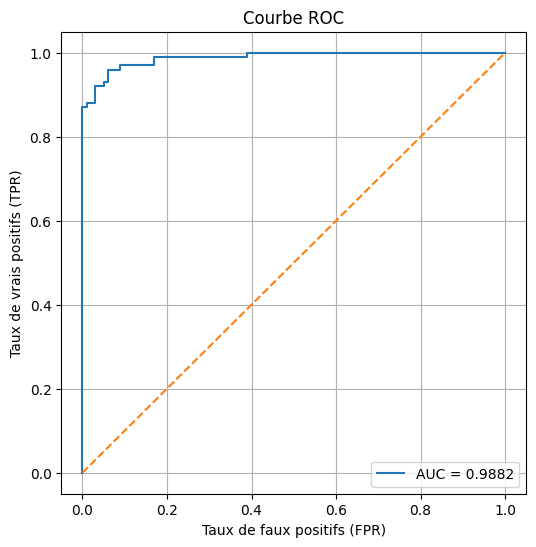

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

y_prob = model.predict(test_generator).ravel()          # Probabilité d'appartenir à la classe 1
y_true = test_generator.classes.astype(int)             # Labels réels (0/1) fournis par le générateur
class_names = list(test_generator.class_indices.keys()) # ['NORMAL', 'PNEUMONIA'] (ordre selon le générateur)

# 2) Seuil par défaut 0.5 pour obtenir des classes prédites
y_pred = (y_prob >= 0.5).astype(int)

# 3) Calcul des métriques
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc = roc_auc_score(y_true, y_prob)

print(f"Accuracy :  {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall :    {recall:.4f}")
print(f"F1-score :  {f1:.4f}")
print(f"AUC :       {auc:.4f}")

# 4) Rapport détaillé + matrice de confusion (optionnel mais utile)
print("\n=== Classification report ===")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# 5) Courbe ROC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


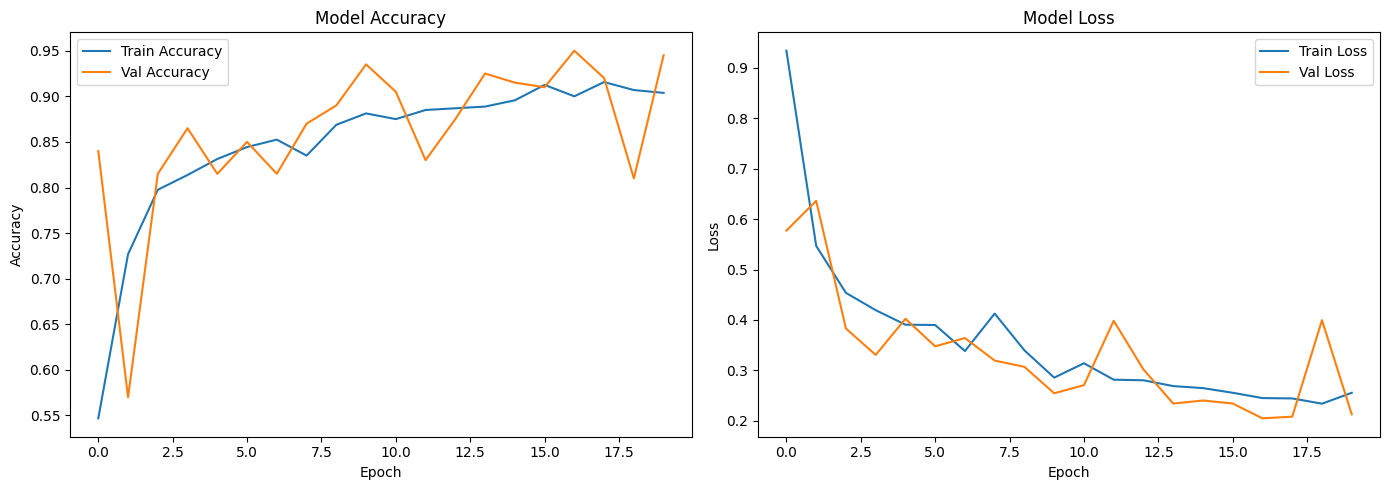

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


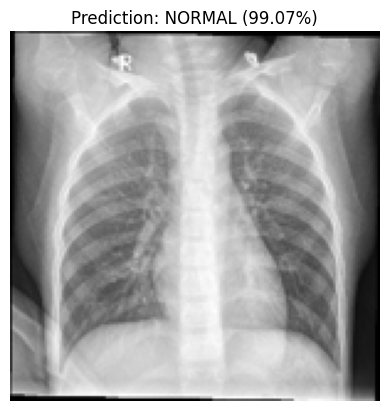

In [ ]:
def classify_local_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        w, h = img.size
        min_dim = min(w, h)
        img = img.crop(((w - min_dim) // 2, (h - min_dim) // 2,
                        (w + min_dim) // 2, (h + min_dim) // 2))
        img = img.resize((150, 150))
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
        prediction = model.predict(img_array)[0][0]
        label = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
        confidence = prediction if prediction > 0.5 else 1 - prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Prediction: {label} ({confidence*100:.2f}%)')
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

classify_local_image('/content/Processed_Data/NORMAL/NORMAL_1072.png')

In [ ]:
import os
import cv2
import pandas as pd
from glob import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

 Comptage par source :
source
generated    30
real         30
dtype: int64


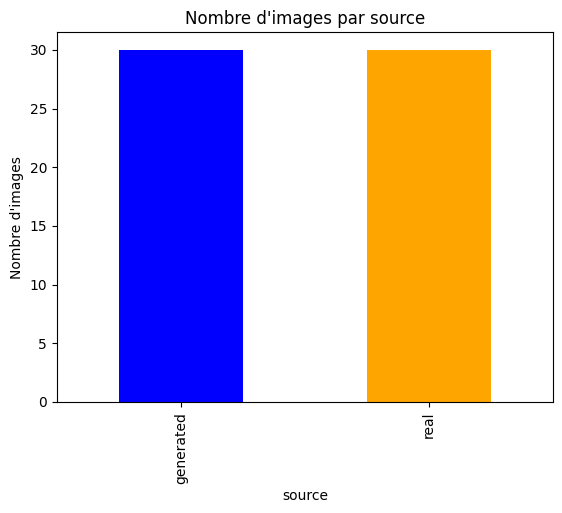

In [ ]:
ORIG_DIR = "30PNEUMO"
GEN_DIR  = "generate"
IMG_SIZE = (150, 150)


def list_images_in_folder(folder, label, source):
    rows = []
    for p in glob(os.path.join(folder, "*")):
        if p.lower().endswith((".png", ".jpg", ".jpeg")):
            rows.append({"path": p, "label": label, "source": source})
    return pd.DataFrame(rows)

def load_gray(path, size=None):
    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if im is None:
        raise ValueError(f"Image illisible: {path}")
    if size is not None:
        im = cv2.resize(im, size)
    return im

def intensity_stats(im):
    arr = im.astype(np.float32)
    return {
        "mean": float(np.mean(arr)),
        "var": float(np.var(arr)),
        "std": float(np.std(arr)),
        "min": float(np.min(arr)),
        "max": float(np.max(arr)),
    }


df_real = list_images_in_folder(ORIG_DIR, "PNEUMONIA", "real")
df_fake = list_images_in_folder(GEN_DIR, "PNEUMONIA", "generated")
df_all = pd.concat([df_real, df_fake], ignore_index=True)

print(" Comptage par source :")
print(df_all.groupby("source").size())


counts = df_all.groupby("source").size()
counts.plot(kind="bar", color=["blue", "orange"])
plt.title("Nombre d'images par source")
plt.ylabel("Nombre d'images")
plt.show()

In [ ]:
stats = []
for _, row in df_all.iterrows():
    im = load_gray(row["path"])
    s = intensity_stats(im)
    s.update({"source": row["source"]})
    stats.append(s)

df_stats = pd.DataFrame(stats)
print("\n Statistiques descriptives moyennes :")
print(df_stats.groupby("source")[["mean", "var", "std", "min", "max"]].mean().round(2))



 Statistiques descriptives moyennes :
             mean      var    std   min     max
source                                         
generated  117.60  2923.11  53.93  0.33  233.07
real       130.75  3810.35  60.88  0.13  247.77


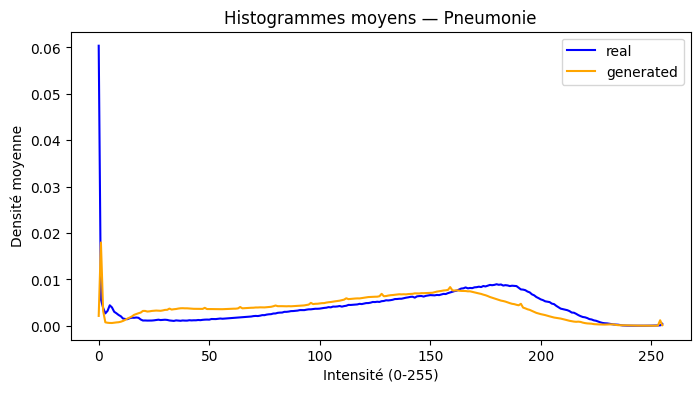

In [ ]:
plt.figure(figsize=(8,4))
for src, color in zip(["real", "generated"], ["blue", "orange"]):
    subset = df_all[df_all["source"] == src].sample(min(50, len(df_all[df_all["source"] == src])), random_state=42)
    hist_accum = np.zeros(256)
    for p in subset["path"]:
        im = load_gray(p)
        h, _ = np.histogram(im.flatten(), bins=256, range=(0,255), density=True)
        hist_accum += h
    hist_accum /= max(1, len(subset))
    plt.plot(range(256), hist_accum, color=color, label=src)
plt.title("Histogrammes moyens — Pneumonie")
plt.xlabel("Intensité (0-255)")
plt.ylabel("Densité moyenne")
plt.legend()
plt.show()

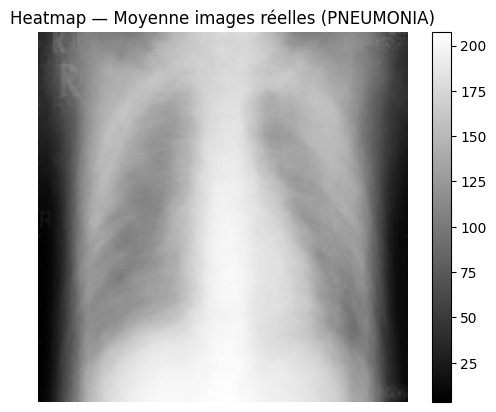

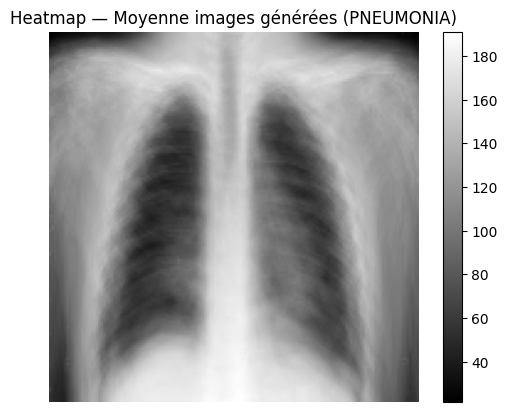

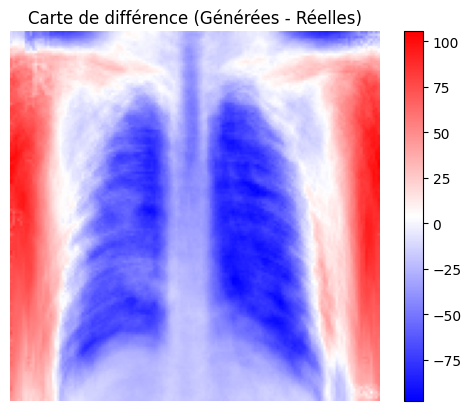

In [ ]:
def mean_image(df_subset, size=IMG_SIZE):
    acc = np.zeros((size[1], size[0]), dtype=np.float64)
    for p in df_subset["path"]:
        im = load_gray(p, size=size)
        acc += im.astype(np.float64)
    return (acc / len(df_subset)).astype(np.float32) if len(df_subset) > 0 else None

mean_real = mean_image(df_real)
mean_fake = mean_image(df_fake)

if mean_real is not None:
    plt.imshow(mean_real, cmap="gray")
    plt.title("Heatmap — Moyenne images réelles (PNEUMONIA)")
    plt.axis("off")
    plt.colorbar()
    plt.show()

if mean_fake is not None:
    plt.imshow(mean_fake, cmap="gray")
    plt.title("Heatmap — Moyenne images générées (PNEUMONIA)")
    plt.axis("off")
    plt.colorbar()
    plt.show()

if mean_real is not None and mean_fake is not None:
    diff = mean_fake - mean_real
    plt.imshow(diff, cmap="bwr")
    plt.title("Carte de différence (Générées - Réelles)")
    plt.axis("off")
    plt.colorbar()
    plt.show()

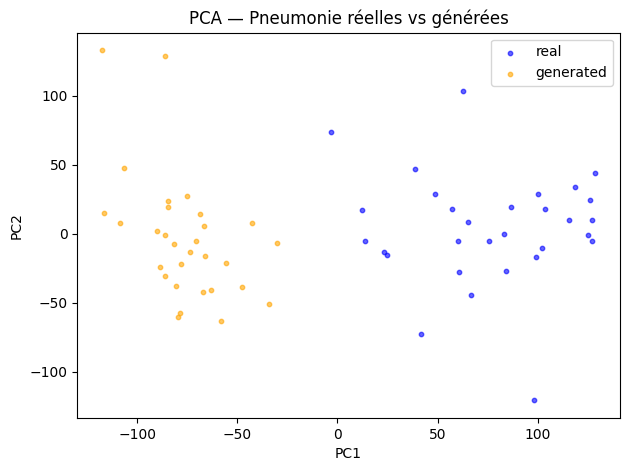

In [ ]:
def features_from_df(df_subset, size=IMG_SIZE):
    X, y_source = [], []
    for _, r in df_subset.iterrows():
        im = load_gray(r["path"], size=size)
        X.append(im.flatten().astype(np.float32))
        y_source.append(r["source"])
    return np.vstack(X), np.array(y_source)

X, y_source = features_from_df(df_all)
X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_std)

plt.figure(figsize=(7,5))
for src, color in zip(["real", "generated"], ["blue", "orange"]):
    mask = (y_source == src)
    plt.scatter(Z[mask, 0], Z[mask, 1], s=10, alpha=0.6, label=src, color=color)
plt.title("PCA — Pneumonie réelles vs générées")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()